# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# Loading Data from the datasets
population_data_main = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers_data_main = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

CPU times: user 52.8 s, sys: 23.1 s, total: 1min 15s
Wall time: 1min 9s


In [3]:
#making a copy of the data loaded to avoid modifying the original data
population_data = population_data_main.copy()
customers_data = customers_data_main.copy()

# Exploring and Analysing the Dataset

##### Step 1: Sneak Peak at the data

In [4]:
population_data.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
customers_data.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


##### Step 2: Identifying NaNs in the dataset Over Rows and Columns

In [6]:
#Identifying the null data (NaN) percentage in the dataset
population_data_NaNs = population_data.isnull().sum()
population_data_NaNs_Percent = population_data_NaNs / len(population_data) * 100

In [7]:
#Top 10 Candidates
population_data_NaNs_Percent.sort_values(ascending=False).head(10)

ALTER_KIND4                  99.864792
ALTER_KIND3                  99.307691
ALTER_KIND2                  96.690047
ALTER_KIND1                  90.904837
EXTSEL992                    73.399639
KK_KUNDENTYP                 65.596749
ALTERSKATEGORIE_FEIN         29.504130
D19_LETZTER_KAUF_BRANCHE     28.849522
D19_LOTTO                    28.849522
D19_VERSI_ONLINE_QUOTE_12    28.849522
dtype: float64

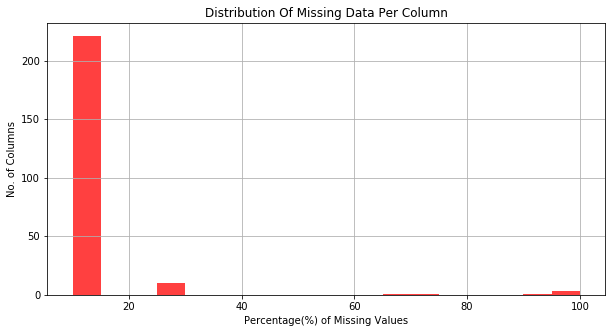

In [8]:
# Visualizig the Null Data
plt.figure(figsize=(10,5))
plt.hist(population_data_NaNs_Percent, bins = np.linspace(10,100,19), facecolor='r', alpha=0.75)
plt.xlabel('Percentage(%) of Missing Values')
plt.ylabel('No. of Columns')
plt.title('Distribution Of Missing Data Per Column')
plt.grid(True)
plt.show()

In [9]:
#Get rows with NaNs
print('Total NaNs Per Rows',population_data.isnull().sum(axis=1).value_counts().sort_index().cumsum())
#get total Rows
print('Total Rows', population_data.isnull().sum(axis=1).shape[0])

Total NaNs Per Rows 0         302
1        1892
2        8880
3       28598
4      147796
        ...  
252    845625
253    891203
256    891204
258    891216
259    891221
Length: 204, dtype: int64
Total Rows 891221


In [10]:
print("Top 15 NaNs Percentage By Row:")
population_data.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:15]/population_data.isnull().sum(axis=1).shape[0]*100,0

Top 15 NaNs Percentage By Row:


(0      0.033886
 1      0.212293
 2      0.996386
 3      3.208856
 4     16.583541
 5     37.966228
 6     56.098543
 7     61.873654
 8     63.318077
 9     63.872934
 10    64.066040
 11    64.290114
 12    64.518565
 13    64.701685
 14    65.184842
 dtype: float64, 0)

In [11]:
Column_Most_NaNs = population_data.isnull().mean()

##### Step 3: Remove NaNs from the Dataset

In [12]:
#Removing all rows from the datset with threshold less than 16
population_data = population_data[population_data.isnull().sum(axis=1) <= 16].reset_index(drop=True)
print('New Dataset Size After Removing the Rows: ',population_data.shape[0])

New Dataset Size After Removing the Rows:  733227


In [13]:
#Removing all columns from the datset with threshold > 65%
Cols_To_Be_Dropped = population_data.columns[Column_Most_NaNs > 0.65]
print('Columns with NaNs > 65%: ', Cols_To_Be_Dropped)

Columns with NaNs > 65%:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [14]:
#Dropping Columns from the population_data 
print('No. of column in population_data before dropping: ', len(population_data.columns))
population_data_orig = population_data
population_data = population_data.drop(Cols_To_Be_Dropped,axis=1)
print('No. of column in population_data after dropping: ', len(population_data.columns))

No. of column in population_data before dropping:  366
No. of column in population_data after dropping:  360


In [15]:
# Drop the extra column of customers dataset.
customers_data.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [16]:
print('# of column in customers before dropping: ', len(customers_data.columns))
customers_data_orig = customers_data
customers_data = customers_data.drop(Cols_To_Be_Dropped,axis=1)
print('# of column in customers after dropping: ', len(customers_data.columns))

# of column in customers before dropping:  366
# of column in customers after dropping:  360


In [17]:
print('Number of rows in new dataset: ',population_data.shape)
print('Number of rows in new dataset: ',customers_data.shape)

Number of rows in new dataset:  (733227, 360)
Number of rows in new dataset:  (191652, 360)


In [18]:
# The column EINGEFUEGT_AM is too spread and diverse
population_data = population_data.drop(['EINGEFUEGT_AM'],axis=1)
customers_data = customers_data.drop(['EINGEFUEGT_AM'],axis=1)

In [19]:
#object field D19_LETZTER_KAUF_BRANCHE is too spread and diverse
population_data = population_data.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers_data = customers_data.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

In [20]:
#Remove Highly Co-related Columns from dataset
def removeCorelatedColumns(data):
    # find correlation matrix    
    corr_matrix = data.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from azdias
    data = data.drop(drop_columns, axis=1)
    return data
    

In [21]:
%%time
print('New No. of Columns, population_data', len(removeCorelatedColumns(population_data).columns))

New No. of Columns, population_data 238
CPU times: user 2min 33s, sys: 13 s, total: 2min 46s
Wall time: 2min 41s


In [22]:
%%time
print('New No. of Columns, customers_data', len(removeCorelatedColumns(customers_data).columns))

New No. of Columns, customers_data 256
CPU times: user 1min, sys: 995 ms, total: 1min 1s
Wall time: 1min 1s


In [23]:
print('Number of rows after removing correlated columns,population_data: ',population_data.shape)
print('Number of rows after removing correlated columns,customers_data: ',customers_data.shape)

Number of rows after removing correlated columns,population_data:  (733227, 358)
Number of rows after removing correlated columns,customers_data:  (191652, 358)


#### Step 4: Handle the remaining NaNs in the dataset

In [24]:
#Let's explore data type in population_data
population_data.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,8A,8,51,W
1,4C,4,24,W
2,2A,2,12,W
3,6B,6,43,W
4,8C,8,54,W
...,...,...,...,...
733222,7A,7,41,W
733223,9D,9,51,W
733224,4C,4,24,W
733225,9D,9,51,W


In [25]:
print('New Number of Columns in population_data', len(population_data.columns))

New Number of Columns in population_data 358


In [26]:
#Let's explore data type in customers_data
customers_data.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,1A,1,13,W
1,NaN,NaN,NaN,NaN
2,5D,5,34,W
3,4C,4,24,W
4,7B,7,41,W


In [28]:
# Identify Numeric and Categorical Columns
population_columns = population_data.columns
numeric_columns = population_data._get_numeric_data().columns
print('Numeric Columns: ',numeric_columns)
print('Categorical Columns: ',list(set(population_columns) - set(numeric_columns)))

Numeric Columns:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=354)
Categorical Columns:  ['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']


In [29]:
#Filling the Missing NaNs
population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = population_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_data[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
population_data[['CAMEO_DEU_2015','OST_WEST_KZ']]=population_data[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers_data[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers_data[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [30]:
customers_data.isnull().sum()

LNR                         0
AGER_TYP                    0
AKT_DAT_KL              46596
ALTER_HH                46596
ALTERSKATEGORIE_FEIN    51842
                        ...  
WOHNDAUER_2008          46596
WOHNLAGE                49927
ZABEOTYP                    0
ANREDE_KZ                   0
ALTERSKATEGORIE_GROB        0
Length: 358, dtype: int64

In [31]:
population_data.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL                   0
ALTER_HH                     0
ALTERSKATEGORIE_FEIN    167182
                         ...  
WOHNDAUER_2008               0
WOHNLAGE                     0
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 358, dtype: int64

In [33]:

# fillna for fields with unknown values
population_data[population_data.columns[(population_data==9).any()]] = population_data[population_data.columns[(population_data==9).any()]].fillna(9)
customers_data[customers_data.columns[(customers_data==9).any()]] = customers_data[customers_data.columns[(customers_data==9).any()]].fillna(9)

population_data[population_data.columns[(population_data==0).any()]] = population_data[population_data.columns[(population_data==0).any()]].fillna(0)
customers_data[customers_data.columns[(customers_data==0).any()]] = customers_data[customers_data.columns[(customers_data==0).any()]].fillna(0)

population_data[population_data.columns[(population_data==-1).any()]] = population_data[population_data.columns[(population_data==-1).any()]].fillna(-1)
customers_data[customers_data.columns[(customers_data==-1).any()]] = customers_data[customers_data.columns[(customers_data==-1).any()]].fillna(-1)

In [34]:
#Handle dummy column trap while encoding
population_data = pd.get_dummies(population_data)
customers_data = pd.get_dummies(customers_data)

In [35]:
#convert to int
population_data = population_data.astype(int)
customers_data = customers_data.astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [36]:
print('Number of Rows in New Dataset, population_data: ',population_data.shape)
print('Number of Rows in New Dataset, customers_data: ',customers_data.shape)

Number of Rows in New Dataset, population_data:  (733227, 404)
Number of Rows in New Dataset, customers_data:  (191652, 405)


In [37]:
print(population_data.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=404)


In [38]:
print(customers_data.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_-1', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=405)


In [39]:
population_columns = population_data.columns
customers_columns = customers_data.columns

In [40]:
# Handling NaNs, as the dataset is large and has many outliers, using Median to fill values

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

population_data = imputer.fit_transform(population_data)
population_data = pd.DataFrame(population_data)
print('imputed population_data: ', population_data.head(5))

customers_data = imputer.fit_transform(customers_data)
customers_data = pd.DataFrame(customers_data)
print('imputed customers_data: ', customers_data.head(5))

/Users/dinesh/opt/anaconda3/envs/ML_Environment/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


imputed population_data:          0    1    2     3     4     5    6    7    8     9    ...  394  395  \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  12.0  ...  0.0  0.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0   7.0  ...  0.0  0.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0   2.0  ...  0.0  0.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0   3.0  ...  0.0  0.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0   2.0  ...  1.0  0.0   

   396  397  398  399  400  401  402  403  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 404 columns]
imputed customers_data:          0    1    2     3     4    5    6    7    8    9    ...  395  396  \
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  1.0  ...  0.0  0.0   
1    9628.0 -1.0  9.0  11.0   9.

In [41]:
print('Number of Rows in New Dataset, population_data: ',population_data.shape)
print('Number of Rows in New Dataset, customers_data: ',customers_data.shape)

Number of Rows in New Dataset, population_data:  (733227, 404)
Number of Rows in New Dataset, customers_data:  (191652, 405)


##### Step 5: Handle outliers in the dataset

In [42]:
%%time
population_data = population_data[(np.abs(stats.zscore(population_data)) < 6).all(axis=1)]
customers_data = customers_data[(np.abs(stats.zscore(customers_data)) < 6).all(axis=1)]

CPU times: user 13.9 s, sys: 26.2 s, total: 40 s
Wall time: 22.9 s


In [43]:
print('Number of Rows in New Dataset: ',population_data.shape)
print('number of rows in new dataset: ',customers_data.shape)

Number of Rows in New Dataset:  (413366, 404)
number of rows in new dataset:  (99455, 405)


In [44]:
#do a check of missing values
population_data.head()

,0,1,2,3,4,5,6,7,8,9,...,394,395,396,397,398,399,400,401,402,403
1,910225.0,-1.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,910244.0,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,910248.0,-1.0,9.0,0.0,9.0,4.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,910261.0,-1.0,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,645165.0,0.0,1.0,10.0,10.0,6.0,0.0,0.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


##### Step 6: Scale the dataset 

In [45]:
%%time
# scale the data
scale = StandardScaler(copy=False)
population_data[population_data.columns] = scale.fit_transform(population_data)
customers_data[customers_data.columns] = scale.fit_transform(customers_data)

CPU times: user 11.1 s, sys: 3.19 s, total: 14.3 s
Wall time: 5.35 s


##### Step 7: Summarize and combine all the steps as dataCleanup() function

In [48]:
def dataCleanUp(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    df = df.drop(drop_columns, axis=1)

    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

    # fillna the fields
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)
    df = pd.get_dummies(df)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)

    # convert to int
    df = df.astype(int)

    # detect and exclude outliers in dataframe  
    if for_clustering:
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 

    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    
    df = df.set_index('LNR')
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

##### Step 1: Reduce the no. of features in the dataset further using PCA technique

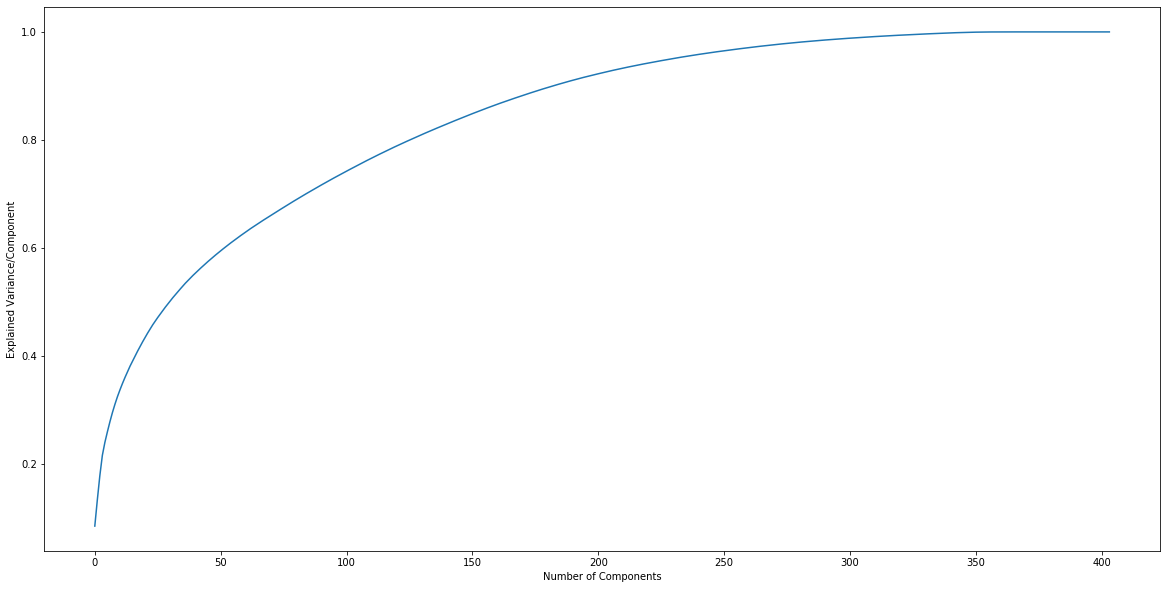

CPU times: user 55.2 s, sys: 7.58 s, total: 1min 2s
Wall time: 18.2 s


In [49]:
%%time
pca = PCA().fit(population_data)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance/Component')
plt.show()

In [50]:
def getWeights(n):
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = population_data.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    return components

In [52]:
#List the wieghts
components = getWeights(1)
print(components)

     Weights
304   0.1369
180   0.1320
308   0.1311
116   0.1268
300   0.1267
..       ...
183  -0.1282
187  -0.1287
13   -0.1296
182  -0.1311
310  -0.1320

[404 rows x 1 columns]


 ##### PCA is a technique to reduce dimensions while maintaining as much as imformation as possible. This technique will have a slight tradeoff in accuracy but will help reduce the numebr of features. From the plot above we can see the plot starts to flatten around 260. We will reduce the data to 260 components.

In [53]:
def reduce_dimensions(df,n=260):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [54]:
print('Variance Ratio for Population and Customer Data:')
reduced_population_data = reduce_dimensions(population_data)
reduced_customers_data = reduce_dimensions(customers_data)

Variance Ratio for Population and Customer Data:
0.970097986248935
0.9917720303882137


In [55]:
print('Number of rows in new dataset: ',reduced_population_data.shape)
print('Number of rows in new dataset: ',reduced_customers_data.shape)

Number of rows in new dataset:  (413366, 260)
Number of rows in new dataset:  (99455, 260)


##### Step 2: Identify ideal number of clusters by using elbow method

In [57]:
#Get K-Means scores by passing data and the no. of clusters
def getScore(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [60]:
#Initialize Clusters Numbers
centers = np.linspace(1,20,20)
centers

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

CPU times: user 6min 4s, sys: 4.49 s, total: 6min 9s
Wall time: 3min 16s


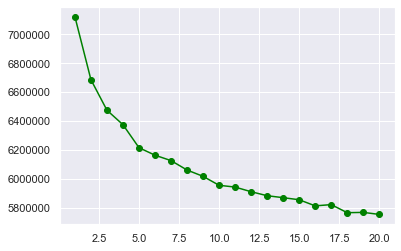

In [94]:
%%time
scores = []
for i in range(1, 21):
    scores.append(getScore(reduced_population_data.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='green')

Text(0.5, 0, 'Number of Clusters')

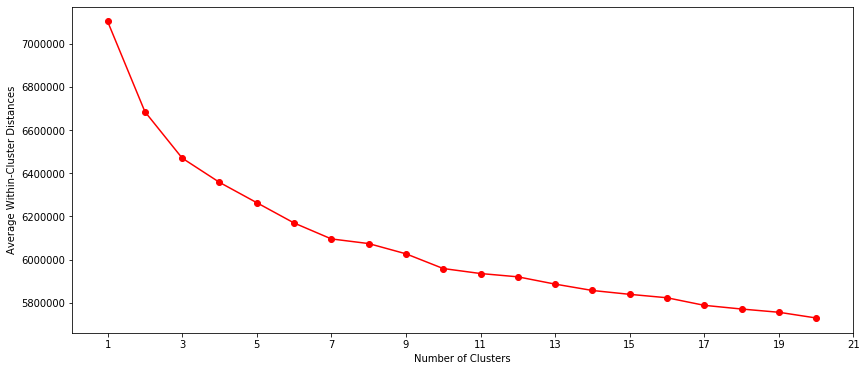

In [62]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='red')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

##### From the chart we can get the ideal number of clusters as 12

In [63]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_population_data)
prediction_population_data = model_k.predict(reduced_population_data)

CPU times: user 20min 15s, sys: 29.6 s, total: 20min 45s
Wall time: 6min 14s


In [65]:
population_clustered = pd.DataFrame(prediction_population_data, columns = ['Cluster'])

In [71]:
prediction_customer_data = model_k.predict(reduced_customers_data)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])

In [72]:
def getDistribution(df, column, height):
    ncount = len(df)
    plt.figure(figsize=(14,6))
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column, data = df)
    plt.title('Distribution of each Cluster')
    plt.xlabel('Cluster Tag')

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Fix the frequency range to 0-100
    ratio = 100 / height
    ax2.set_ylim(0,100 / ratio)
    ax.set_ylim(0,ncount / ratio)

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

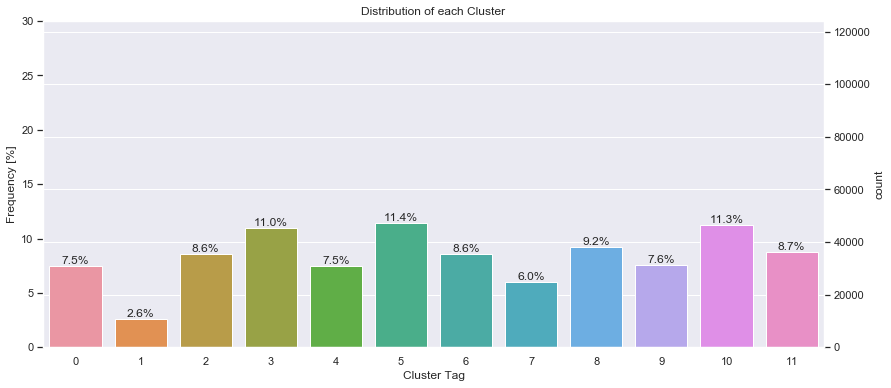

In [73]:
df_prediction_population = pd.DataFrame(prediction_population_data, columns = ['Cluster'])
getDistribution(df_prediction_population, 'Cluster', height = 30)

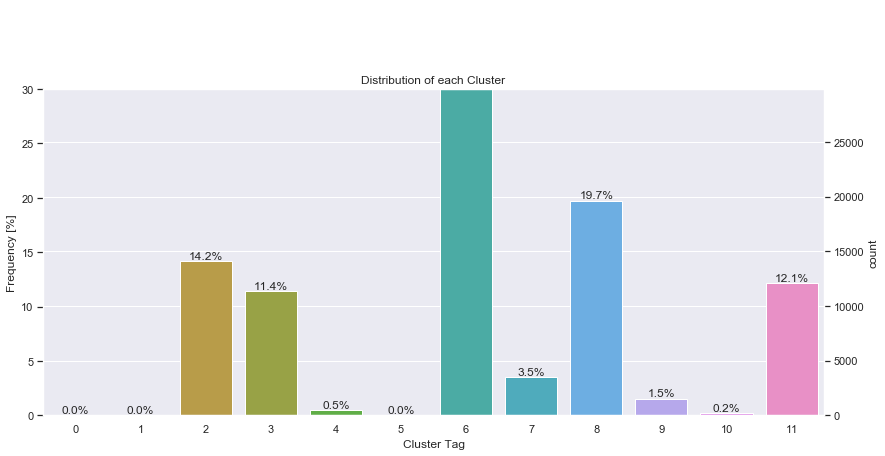

In [74]:
df_prediction_customers = pd.DataFrame(prediction_customer_data, columns = ['Cluster'])
getDistribution(df_prediction_customers, 'Cluster', height = 30)

#### Step 3: Getting data from population and customer dataset for comparision

In [164]:
# Count number of predictions for each customer segment
customer_clusters = pd.Series(prediction_customer_data)
cc_counts = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_population_data)
pc_counts = population_clusters.value_counts().sort_index()

In [165]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc_counts], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

,cluster,population,customer,difference
0,0,30807,10,-7.442663
1,1,10629,31,-2.540159
2,2,35484,14132,5.625281
3,3,45506,11370,0.423660
4,4,31032,451,-7.053677
5,5,47329,43,-11.406424
6,6,35598,36481,28.069172
7,7,24780,3498,-2.477519
8,8,38218,19624,10.485977
9,9,31237,1523,-6.025396


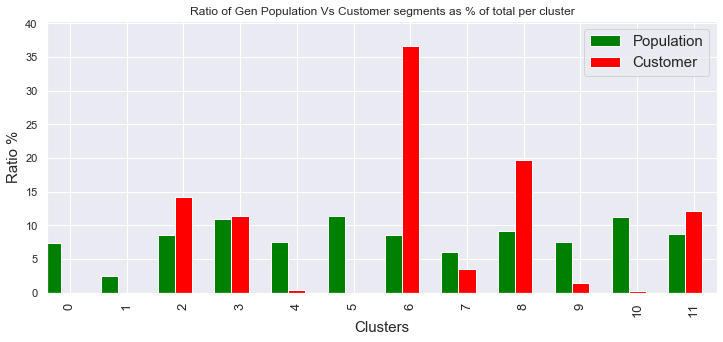

In [169]:
# Compare the proportion of data in each cluster for the customer data to the
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='green',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='red',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

##### Step 1: Get the data and split it as train and test

In [81]:
#reading the dataset
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/dinesh/opt/anaconda3/envs/ML_Environment/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
#getting features and label
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

##### Step 2: Process data and cleanup

In [83]:
# preprocess data using the cleanup function
df_mailout_train  = dataCleanUp(X, False)

/Users/dinesh/opt/anaconda3/envs/ML_Environment/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [84]:
df_mailout_train.shape

(42962, 299)

In [85]:
y.shape

(42962,)

In [86]:
df_mailout_train.head(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655987,0.323502,0.396516,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-0.860749,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655785,0.323502,-0.545883,-0.192755,-0.681567,-0.518285,2.042255,-0.204857,-1.101855,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,2.023489,-1.284655
-1.668538,1.031262,-0.545883,-0.729667,-0.934679,-0.227168,-0.499090,-0.204857,-0.402222,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655502,1.031262,-0.545883,-0.192755,-0.175344,3.339007,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419


In [87]:
# Split the dataset into Train/Validation/Test
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

##### Step 3: Slect an algorithm for base line

In [166]:
#using XBBoost as the algorithm for our use case as it works best for classification
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

[00:59:16] WARNING: /usr/local/miniconda/conda-bld/xgboost_1584539872846/work/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [167]:
prediction = xg_reg.predict(X_val)

In [168]:
prediction

array([0.18258125, 0.18258125, 0.18258125, ..., 0.18258125, 0.18258125,
       0.18258125], dtype=float32)

In [91]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.5000


##### Step 4: Finalize the parameters for  algorithm

In [106]:
clf_final = xgb.XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500,
    scoring = 'roc_auc')

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

0.7837570426762837


#### Step 5: Identify important features from supervised learning

In [135]:
feat_importance = clf_final.feature_importances_

array([2.9300856e-03, 2.4756819e-03, 3.4327696e-03, 3.9282446e-03,
       3.2375711e-03, 3.1140130e-03, 1.1656587e-03, 4.3504261e-03,
       2.1443425e-03, 4.6752454e-03, 5.6532999e-03, 3.2138915e-03,
       3.4023779e-03, 3.0834670e-03, 1.8211633e-03, 2.3940797e-03,
       2.4226485e-03, 2.2680024e-03, 2.0449720e-03, 3.9663441e-03,
       5.7880781e-03, 0.0000000e+00, 3.4485958e-03, 4.1057249e-03,
       3.5254946e-03, 4.0139621e-03, 5.7446053e-03, 1.5993302e-03,
       4.5743934e-03, 9.1511232e-04, 3.1302539e-03, 2.2688410e-03,
       5.4607433e-03, 0.0000000e+00, 3.0194859e-03, 4.5331535e-03,
       2.1476466e-03, 3.9690193e-03, 4.8143002e-03, 3.9258655e-03,
       3.2435234e-03, 2.8549405e-03, 5.2904938e-03, 1.5255557e-03,
       3.8929132e-03, 4.4590398e-03, 4.4048913e-03, 3.1762808e-03,
       3.1625773e-03, 1.4085830e-02, 3.8810512e-03, 0.0000000e+00,
       5.7378253e-03, 6.1602676e-03, 1.0274816e-03, 0.0000000e+00,
       4.9499235e-05, 2.0894150e-03, 3.5619596e-03, 4.8987945e

['D19_SOZIALES' 'KBA13_KRSSEG_VAN' 'KBA05_KRSVAN' 'KBA05_ANHANG'
 'KBA13_SEG_UTILITIES']
[0.01408583 0.00753325 0.00745248 0.00676646 0.00641327]


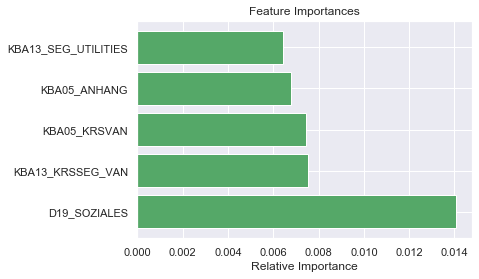

In [136]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='g', align='center', label = "Feature Weight")

plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

##### Step 1: Get the data and split it as train and test

In [157]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/dinesh/opt/anaconda3/envs/ML_Environment/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [158]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

##### Step 2: Data cleanup

In [159]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = dataCleanUp(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)


/Users/dinesh/opt/anaconda3/envs/ML_Environment/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


after preprocessing mailout_test_clean.shape:  (42833, 299)


##### Step 3: Predict the Output

In [160]:
prediction_for_kaggle = clf_final.predict(mailout_test_clean)

In [161]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [162]:
df_kaggle.head(10)

,RESPONSE
LNR,
1754,0.035161
1770,0.035284
1465,0.007356
1470,0.008121
1478,0.011761
1782,0.006371
1485,0.008821
1519,0.022835
1835,0.025162


##### Step 4: Save the results

In [163]:
df_kaggle.to_csv('submission.csv')

### References:

- https://jakevdp.github.io/PythonDataScienceHandbook/index.html
- https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
- https://stats.stackexchange.com/questions/143700/which-is-better-replacement-by-mean-and-replacement-by-median
- https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
- https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
- https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/